<a href="https://colab.research.google.com/github/gerardburgues/Clickbait-prediction/blob/main/BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clickbait detector


## Import Libraries


In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 462 kB 44.8 MB/s 


In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import pandas as pd
import numpy as np

from imblearn.under_sampling import RandomUnderSampler

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text



## Data Load


In [ ]:
df = pd.read_csv('webis_train.csv', sep=',', names=['PostMedia'
                                                ,'postText'
                                                ,'id'
                                                ,'targetCaptions'
                                                ,'targetParagraphs'
                                                ,'targetTitle'
                                                ,'postTimestamp'
                                                ,'targetKeywords'
                                                ,'targetDescription'
                                                ,'truthJudgments'
                                                ,'truthMean'
                                                ,'truthClass'
                                                ,'truthMedian'
                                                ,'truthMode'])

In [ ]:
df.head()

,PostMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
NaN,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
0.0,[],UK’s response to modern slavery leaving victim...,858462320779026432,['modern-slavery-rex.jpg'],['Thousands of modern slavery victims have\xa0...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.13333333332,no-clickbait,0.0,0.0
1.0,[],this is good,858421020331560960,"['In this July 1, 2010 file photo, Dr. Charmai...",['President Donald Trump has appointed the\xa0...,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.0,clickbait,1.0,1.0
2.0,[],"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,"[""President Trump will not attend this year's ...",['When the\xa0White House correspondents’ dinn...,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.46666666663999995,no-clickbait,0.33333333330000003,0.33333333330000003
3.0,[],Meet the happiest #dog in the world!,858323428260139008,"['Maru ', 'Maru', 'Maru', 'Maru', 'Maru']",['Adorable is probably an understatement. This...,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,"Maru, husky, dogs, pandas, furball, instagram","The article is about Maru, a husky dog who has...","[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]",0.9333333333199999,clickbait,1.0,1.0


In [ ]:
df = df.iloc[1:, [1,11]]
df.head().reset_index(drop=True)

,postText,truthClass
0,UK’s response to modern slavery leaving victim...,no-clickbait
1,this is good,clickbait
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait
3,Meet the happiest #dog in the world!,clickbait
4,Tokyo's subway is shut down amid fears over an...,no-clickbait


In [ ]:
#When truthClass is clickbait then 1  
df.loc[df['truthClass'] == 'clickbait', 'TC'] = 1
#When truthClass is clickbait then 1  
df.loc[df['truthClass'] != 'clickbait', 'TC'] = 0
df = df.drop(['truthClass'], axis=1)

In [ ]:
df.head()

,postText,TC
0.0,UK’s response to modern slavery leaving victim...,0.0
1.0,this is good,1.0
2.0,"The ""forgotten"" Trump roast: Relive his brutal...",0.0
3.0,Meet the happiest #dog in the world!,1.0
4.0,Tokyo's subway is shut down amid fears over an...,0.0


Now that I have cleaned and selected which columns we are interested in the dataset I'll proceed to analyse the data to complete the final goal. 
I've already decoded the truthclass (string) into a 1/0 parameter. 

First we are interested in the following parameter:

**TRUTHCLASS**

Is the dataset even? --> 
Do we have the same quantity of data for each type of TC?





making sure we have two unique TC  2
Showing occurances for TC = 0 and TC = 1


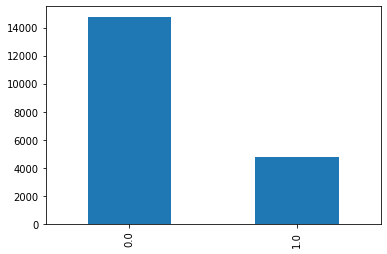

In [ ]:
print('making sure we have two unique TC ' , df['TC'].nunique())
print('Showing occurances for TC = 0 and TC = 1')
df['TC'].value_counts()
df['TC'].value_counts().plot.bar()

As we can see we do not have a balanced data.
To treat this problem I'll use a resampling technique (Undersampling).

As I'll be using BERT I think that I
'll still have enough data to play with. In case my final result is not the expected one, I'll find a better aproach. 

Before applying the undersampling it is better to remove all those rows that have null values. 
They don't bring any information. 


In [ ]:
#Before balancing the data we remove any row that doesn't provide data
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

postText    54
dtype: int64

In [ ]:
#Remove row if there is null value
df = df.dropna()

In [ ]:
df.isna()

,postText,TC
0.0,False,False
1.0,False,False
2.0,False,False
3.0,False,False
4.0,False,False
...,...,...
19533.0,False,False
19534.0,False,False
19535.0,False,False
19536.0,False,False


class 0 (14768, 2)
class 1 (4716, 2)
total class of 1 and0: 0.0    4716
1.0    4716
Name: TC, dtype: int64


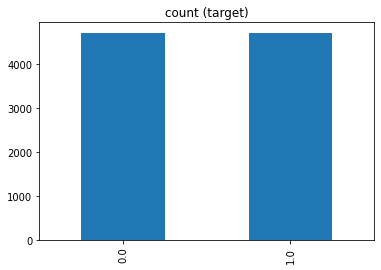

In [ ]:
class_count_0, class_count_1 = df['TC'].value_counts()

class_0 = df[df['TC'] == 0]
class_1 = df[df['TC'] == 1]
print('class 0' , class_0.shape)
print('class 1' , class_1.shape)

class_0_under = class_0.sample(class_count_1)

df_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and0:",df_under['TC'].value_counts())# plot the count after under-sampeling
df_under['TC'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
df_under.head()
cloudData = df_under.copy()

In [ ]:
print(cloudData)

                                                  postText   TC
2242.0                Islamophobia is on the rise in China  0.0
9062.0   How a president can use orders and memos, and ...  0.0
6976.0   A man holding a #machete was shot and injured ...  0.0
8592.0   Vince Carter ejected for throwing elbow at Dev...  0.0
15144.0  50 Cent mercilessly trolls Soulja Boy after al...  0.0
...                                                    ...  ...
19518.0  CenturyLinkVoice: New product launch: Testing ...  1.0
19526.0                        We'll always have Newsweek.  1.0
19529.0  18 uplifting documentaries guaranteed to put a...  1.0
19532.0  12 things you realize at the end of a relation...  1.0
19534.0                                     😱😱😱😱😱😱😱😱😱😱😱😱😱😱  1.0

[9432 rows x 2 columns]


As you can see in the following cell we do not have any null value 



In [ ]:
null_columns=df_under.columns[df_under.isnull().any()]
df_under[null_columns].isnull().sum()


Series([], dtype: float64)

Now we know we don't have any row with null values I can start the preprocessing part:

- Remove stopwords
- Lower case words
- Removing punctuation

In [ ]:

stop_words = stopwords.words('english')


In [ ]:

df_under['postText']=df_under['postText'].convert_dtypes()


In [ ]:
df_under.dtypes


postText     string
TC          float64
dtype: object

In [ ]:
df_under['postText'] = df_under['postText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_under['postText'] = df_under['postText'].str.lower()
df_under["postText"] = df_under['postText'].str.replace('[^\w\s]','')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:

p = PorterStemmer()
for i in range(0, df_under.shape[0]-1):
  df_under["postText"].iloc[i] = p.stem(df_under['postText'].iloc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
l = WordNetLemmatizer()
for i in range(0, df_under.shape[0]-1):
  df_under["postText"].iloc[i] = l.lemmatize(df_under['postText'].iloc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
null_columns=df_under.columns[df_under["postText"].isnull().any()]
df_under[null_columns].isnull().sum()


Series([], dtype: float64)

In [ ]:
##for i in range(0, df_under.shape[0]-1):
##  df_under["postText"].iloc[i] = word_tokenize(df_under["postText"].iloc[i])

In [ ]:
df_under

,postText,TC
2242.0,islamophobia rise china,0.0
9062.0,how president use orders memos stop them,0.0
6976.0,a man holding machete shot injured security fo...,0.0
8592.0,vince carter ejected throwing elbow devin book...,0.0
15144.0,50 cent mercilessly trolls soulja boy alleged ...,0.0
...,...,...
19518.0,centurylinkvoice new product launch testing wa...,1.0
19526.0,well always newsweek,1.0
19529.0,18 uplifting documentaries guaranteed put smil...,1.0
19532.0,12 things realize end relationship,1.0


The following question to answer is:

--> Which words are the most common for each class?

**Remember TC = 1 is clickbait** 

In [ ]:
def generateCloud(text):
  wordcloud = WordCloud().generate(text)
  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
def generatingCloudText(type):
  text = cloudData.postText[:].where(cloudData['TC']== type)
  text = text.dropna()
  text = text.to_frame()
  out = ' '.join(text["postText"])
  return out

In [ ]:
print(cloudData)
out_0 = generatingCloudText(0)
out_1 = generatingCloudText(1)

                                                  postText   TC
2242.0                Islamophobia is on the rise in China  0.0
9062.0   How a president can use orders and memos, and ...  0.0
6976.0   A man holding a #machete was shot and injured ...  0.0
8592.0   Vince Carter ejected for throwing elbow at Dev...  0.0
15144.0  50 Cent mercilessly trolls Soulja Boy after al...  0.0
...                                                    ...  ...
19518.0  CenturyLinkVoice: New product launch: Testing ...  1.0
19526.0                        We'll always have Newsweek.  1.0
19529.0  18 uplifting documentaries guaranteed to put a...  1.0
19532.0  12 things you realize at the end of a relation...  1.0
19534.0                                     😱😱😱😱😱😱😱😱😱😱😱😱😱😱  1.0

[9432 rows x 2 columns]


Appearence of words when truthClass is 0


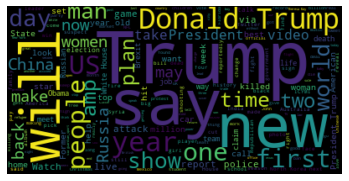

Appearence of words when truthClass is 1


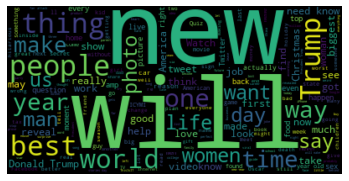

In [ ]:
#Generating cloud of words when TC = 0
print("Appearence of words when truthClass is 0")
generateCloud(out_0)
#Generating cloud of words when TC = 1
print("Appearence of words when truthClass is 1")
generateCloud(out_1)


##BERT model

###Downloadinng Bert with Keras

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

I'll build the model using Tensorflow-Keras

In [ ]:
# First initialize the Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [ ]:
#Initializing the Neural Network Layers
#We may add more layers  
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l1 = tf.keras.layers.Dense(100, activation='sigmoid')(l)
l2 = tf.keras.layers.Dense(50, activation='sigmoid')(l1)
l3 = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l2)
model = tf.keras.Model(inputs=[text_input], outputs = [l3])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [ ]:
X_train = df_under['postText']
y_train = df_under['TC']


In [ ]:
model.fit(X_train.to_list(), y_train.to_list(), epochs=50)

Epoch 1/50
295/295 [==============================] - 219s 687ms/step - loss: 0.6198 - accuracy: 0.6490 - precision: 0.6510 - recall: 0.6423
Epoch 2/50
295/295 [==============================] - 202s 683ms/step - loss: 0.5403 - accuracy: 0.7314 - precision: 0.7281 - recall: 0.7388
Epoch 3/50
295/295 [==============================] - 201s 683ms/step - loss: 0.5304 - accuracy: 0.7407 - precision: 0.7368 - recall: 0.7489
Epoch 4/50
295/295 [==============================] - 203s 687ms/step - loss: 0.5240 - accuracy: 0.7451 - precision: 0.7388 - recall: 0.7583
Epoch 5/50
295/295 [==============================] - 202s 686ms/step - loss: 0.5177 - accuracy: 0.7465 - precision: 0.7425 - recall: 0.7547
Epoch 6/50
295/295 [==============================] - 203s 687ms/step - loss: 0.5145 - accuracy: 0.7514 - precision: 0.7487 - recall: 0.7568
Epoch 7/50
295/295 [==============================] - 201s 681ms/step - loss: 0.5109 - accuracy: 0.7512 - precision: 0.7471 - recall: 0.7593
Epoch 8/50
29

In [ ]:
from keras.models import load_model

model.save('my_model.h5') 

In [ ]:
from keras.models import load_model
saved = load_model('my_model.h5')
saved.summary()

NameError: ignored